In [37]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [38]:
CLASSES_dict = {'Amusement':0, 'Anger':1, 'Awe':2, 'Contentment':3, 'Disgust':4, 'Excitement':5, 'Fear':6, 'Sadness':7}
data_path = r'dataset/Artphoto'
img_paths = glob.glob('dataset/Artphoto/*/*.jpg')

In [39]:
img_paths

['dataset/Artphoto/Disgust/disgust_0794.jpg',
 'dataset/Artphoto/Disgust/disgust_0804.jpg',
 'dataset/Artphoto/Disgust/disgust_0795.jpg',
 'dataset/Artphoto/Disgust/disgust_0779.jpg',
 'dataset/Artphoto/Disgust/disgust_0897.jpg',
 'dataset/Artphoto/Disgust/disgust_0764.jpg',
 'dataset/Artphoto/Disgust/disgust_0886.jpg',
 'dataset/Artphoto/Disgust/disgust_0798.jpg',
 'dataset/Artphoto/Disgust/disgust_0899.jpg',
 'dataset/Artphoto/Disgust/disgust_0792.jpg',
 'dataset/Artphoto/Disgust/disgust_0758.jpg',
 'dataset/Artphoto/Disgust/disgust_0882.jpg',
 'dataset/Artphoto/Disgust/disgust_0805.jpg',
 'dataset/Artphoto/Disgust/disgust_0895.jpg',
 'dataset/Artphoto/Disgust/disgust_0782.jpg',
 'dataset/Artphoto/Disgust/disgust_0772.jpg',
 'dataset/Artphoto/Disgust/disgust_0771.jpg',
 'dataset/Artphoto/Disgust/disgust_0765.jpg',
 'dataset/Artphoto/Disgust/disgust_0759.jpg',
 'dataset/Artphoto/Disgust/disgust_0887.jpg',
 'dataset/Artphoto/Disgust/disgust_0889.jpg',
 'dataset/Artphoto/Disgust/disgust

In [41]:
#generating data for cross-validation
img_data = np.zeros(shape=(len(img_paths), 224,224,3))
img_labels = np.zeros(shape=(len(img_paths),))

count = 0
for path in img_paths:
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    swap = img[:,:,0].copy()
    img[:,:,0] = img[:,:,2]
    img[:,:,2] = swap
    cls = path.split("/")[2]
    img_data[count] = img
    img_labels[count] = CLASSES_dict[str(cls)]
    count += 1
    if count % 50 == 0:
        print(f'Done for {count} images')
print(f'Done for {count} images')

Done for 50 images
Done for 100 images
Done for 150 images
Done for 200 images
Done for 250 images
Done for 300 images
Done for 350 images
Done for 400 images
Done for 450 images
Done for 500 images
Done for 550 images
Done for 600 images
Done for 650 images
Done for 700 images
Done for 750 images
Done for 800 images
Done for 806 images


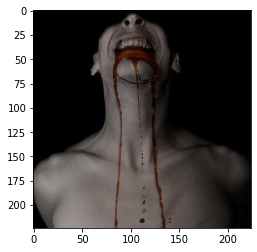

In [45]:
plt.imshow(img_data[8] * 1./255)
#img_data[0]

In [137]:
NUM_CLASSES = 8
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
test_dir = r'dataset/Ours_OnlyTest_withoutFunny'

preprocess_fun = tf.keras.applications.densenet.preprocess_input

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0,
                                  preprocessing_function=preprocess_fun
                                 )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 2146 images belonging to 8 classes.


In [138]:
test_generator.labels.shape

(2146,)

In [139]:
#for test labels
np.save(r'FeatureFiles/Ours_OnlyTest_withoutFunny_testlabels_multilabel.npy', test_generator.labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


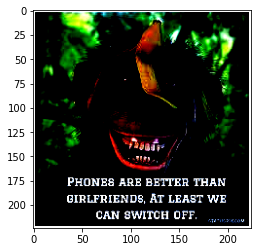

In [112]:
plt.imshow(test_generator[0][0][3] * 255)

In [113]:
emotion_model = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

def emotion_model_feature_extractor(inputs):
    y = emotion_model(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model, mainobject_model):
    x, emotion_features = emotion_model(inputs)
    mainobject_features = mainobject_model(inputs)
    
    merged_features = tf.concat([mainobject_features, emotion_features], axis=1)
    classification_output = classifier(merged_features)
    
    return merged_features, classification_output

def define_compile_model(emotionweights_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model = tf.keras.Model(inputs= inputs, outputs= emotion_model_feature_extractor(inputs))
    emotion_model.load_weights(emotionweights_path)
    mainobject_model = tf.keras.applications.densenet.DenseNet201(input_shape=(224,224,3), include_top= True, 
                                                                 weights='imagenet')
    mainobject_model.trainable = False
    
    features, classification_output = final_model(inputs, emotion_model, mainobject_model) 
    model = tf.keras.Model(inputs= inputs, outputs= [features, classification_output])
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [114]:
emotionweights_path = r'h5 files/DenseNet201-010-0.780538-0.641440.h5'
model = define_compile_model(emotionweights_path)
modelweights_path = r'h5 files/Idea1_DenseNet201-002-0.776119-0.647849.h5'
model.load_weights(modelweights_path)

In [115]:
features, x = model.predict(test_generator)

41/41 [==============================] - 127s 3s/step


In [116]:
features.shape

(2565, 2920)

In [117]:
np.save(r'FeatureFiles/Ours_OnlyTest_withFunny_DenseNet201_featuresdata.npy', features)

In [47]:
skf = StratifiedKFold(n_splits=5)
for train_idices, test_idices in skf.split(img_data, img_labels,):
    

In [49]:
print(train.shape)
test.shape

(644,)


(162,)